# A short qualitative error analysis

I'm going to look at the results of the joint Thai-English normal text training task. I have a (small!) hypothesis that the model hasn't learned to distinguish between similarly-shaped English and Thai letters very well.

Let's grab five examples of the letter A from the test set of that model run:

```sh
cat /home/gusandmich@GU.GU.SE/assignment_1_run_results/runs/thai_english_normal_jointly/data/testing_set.txt | grep "English,200,normal,065," | head -n5 > test_ds.txt
``` 

Now let's try running the model, trained on Thai-English normal text jointly, on these letters and see what predictions we get.

In [41]:
import torch 
import sys
sys.path.append('../assignment_code')
from model import BasicNetwork
import utils 
from PIL import Image 
from torchvision.transforms import Resize
from torchvision.transforms.functional import pil_to_tensor, to_pil_image
import matplotlib.pyplot as plt


In [65]:
# Lookup from the dataset numerical encoding to the actual letter
mappings_path = "/scratch/lt2326-2926-h24/ThaiOCR/ThaiOCR-TrainigSet/Numeric/20110202-List-Code-Character-OCR-Training-Database.txt"

char_mappings = {}
with open(mappings_path, encoding="windows-1252") as f:
    for line in f.readlines():
        splt = line.split()
        if len(splt) > 1:
            idx, chr = (splt[0], splt[1])
            char_mappings[int(idx)] = chr


In [7]:
model_path = "/home/gusandmich@GU.GU.SE/assignment_1_run_results/runs/thai_english_normal_jointly/outputs/model.pth"
model = BasicNetwork(utils.NUM_CLASSES, 64)
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
model.load_state_dict(torch.load(model_path, weights_only=True))
model.to(device)

BasicNetwork(
  (feature): Sequential(
    (0): Conv2d(1, 6, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
    (1): Tanh()
    (2): AvgPool2d(kernel_size=4, stride=2, padding=0)
    (3): Conv2d(6, 16, kernel_size=(5, 5), stride=(1, 1))
    (4): Tanh()
    (5): AvgPool2d(kernel_size=4, stride=2, padding=0)
  )
  (classifier): Sequential(
    (0): Flatten(start_dim=1, end_dim=-1)
    (1): Linear(in_features=2304, out_features=120, bias=True)
    (2): Tanh()
    (3): Linear(in_features=120, out_features=84, bias=True)
    (4): Tanh()
    (5): Linear(in_features=84, out_features=286, bias=True)
  )
)

In [8]:
test_files = ["/scratch/lt2326-2926-h24/ThaiOCR/ThaiOCR-TrainigSet/English/065/200/normal/FSEB212_200_10_16_065.bmp", 
              "/scratch/lt2326-2926-h24/ThaiOCR/ThaiOCR-TrainigSet/English/065/200/normal/FSES213_200_11_20_065.bmp", 
              "/scratch/lt2326-2926-h24/ThaiOCR/ThaiOCR-TrainigSet/English/065/200/normal/PPEB211_200_10_08_065.bmp", 
              "/scratch/lt2326-2926-h24/ThaiOCR/ThaiOCR-TrainigSet/English/065/200/normal/JTEB212_200_10_18_065.bmp", 
              "/scratch/lt2326-2926-h24/ThaiOCR/ThaiOCR-TrainigSet/English/065/200/normal/IRES212_200_11_16_065.bmp"]

Image: 


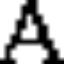

Top five predicted classes: 
Class: 167
Character mapping: §
Prediction: 3.512225866317749

Class: 214
Character mapping: ÍÖ
Prediction: 3.231112003326416

Class: 230
Character mapping: æ
Prediction: 3.1296260356903076

Class: 178
Character mapping: ²
Prediction: 3.0809879302978516

Class: 65
Character mapping: A
Prediction: 3.0626657009124756

Image: 


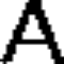

Top five predicted classes: 
Class: 167
Character mapping: §
Prediction: 3.6596262454986572

Class: 214
Character mapping: ÍÖ
Prediction: 3.578819513320923

Class: 65
Character mapping: A
Prediction: 3.0756256580352783

Class: 230
Character mapping: æ
Prediction: 2.96547532081604

Class: 170
Character mapping: ª
Prediction: 2.8144917488098145

Image: 


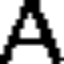

Top five predicted classes: 
Class: 214
Character mapping: ÍÖ
Prediction: 3.7159111499786377

Class: 167
Character mapping: §
Prediction: 3.600536584854126

Class: 65
Character mapping: A
Prediction: 3.165142059326172

Class: 237
Character mapping: ÍÓ
Prediction: 2.921231508255005

Class: 230
Character mapping: æ
Prediction: 2.703238010406494

Image: 


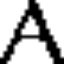

Top five predicted classes: 
Class: 167
Character mapping: §
Prediction: 3.6568098068237305

Class: 214
Character mapping: ÍÖ
Prediction: 3.3031952381134033

Class: 230
Character mapping: æ
Prediction: 3.2596828937530518

Class: 170
Character mapping: ª
Prediction: 2.9609270095825195

Class: 65
Character mapping: A
Prediction: 2.9561479091644287

Image: 


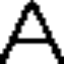

Top five predicted classes: 
Class: 167
Character mapping: §
Prediction: 3.6841583251953125

Class: 230
Character mapping: æ
Prediction: 3.494157552719116

Class: 188
Character mapping: ¼
Prediction: 3.301923990249634

Class: 214
Character mapping: ÍÖ
Prediction: 3.217288017272949

Class: 207
Character mapping: Ï
Prediction: 3.15029239654541



In [82]:
test = utils.load_datasets(["./test_ds.txt"], 20)

for idx, data in enumerate(test.loader, 0):
    inputs, labels = data[0].to(device), data[1].to(device)
    predicted = model(inputs)
    
    for i in range(len(inputs)):
        img = inputs[i]
        cls_preds = predicted[i]
        most_likely = cls_preds.argsort(dim=0, descending=True)[:5].cpu().numpy()
        print("Image: ")
        display(to_pil_image(img[0].cpu()))
        print("Top five predicted classes: ")
        for x in most_likely:
            print(f"Class: {x}")
            print(f"Character mapping: {char_mappings[x]}")
            print(f"Prediction: {cls_preds[x].cpu().detach().numpy()}")
            print()


It looks like the model most often confuses classes 167, 214, and 230 for the letter A - although A is in the top five predictions in all cases! 

Let's look these up and see which Thai letter they correspond to. 

```
$ cat /home/gusandmich@GU.GU.SE/assignment_1_run_results/runs/thai_english_normal_jointly/data/testing_set.txt | grep ",167," | head -n1 | cut -d ',' -f 5

/scratch/lt2326-2926-h24/ThaiOCR/ThaiOCR-TrainigSet/Thai/167/200/normal/Bwts212_200_11_16_167.bmp


$ cat /home/gusandmich@GU.GU.SE/assignment_1_run_results/runs/thai_english_normal_jointly/data/testing_set.txt | grep ",214," | head -n1 | cut -d ',' -f 5

/scratch/lt2326-2926-h24/ThaiOCR/ThaiOCR-TrainigSet/Thai/214/200/normal/Dltb211_200_10_08_214.bmp


$ cat /home/gusandmich@GU.GU.SE/assignment_1_run_results/runs/thai_english_normal_jointly/data/testing_set.txt | grep ",230," | head -n1 | cut -d ',' -f 5

/scratch/lt2326-2926-h24/ThaiOCR/ThaiOCR-TrainigSet/Thai/230/200/normal/FSTB211_200_10_10_230.bmp

```

Class: 167
Original image:


Resized image:


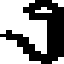

Class: 214
Original image:


Resized image:


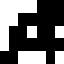

Class: 230
Original image:


Resized image:


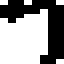

In [81]:
classes = {
    167: "/scratch/lt2326-2926-h24/ThaiOCR/ThaiOCR-TrainigSet/Thai/167/200/normal/Bwts212_200_11_16_167.bmp", 
    214: "/scratch/lt2326-2926-h24/ThaiOCR/ThaiOCR-TrainigSet/Thai/214/200/normal/Dltb211_200_10_08_214.bmp",
    230: "/scratch/lt2326-2926-h24/ThaiOCR/ThaiOCR-TrainigSet/Thai/230/200/normal/FSTB211_200_10_10_230.bmp"
}

for c in classes:
    print(f"Class: {c}")
    img = Image.open(classes[c])
    print("Original image:")
    display(img)
    print("Resized image:")
    display(img.resize((64, 64)))

You can see why the model might confuse these for the letter A. 214 is very similar - it's practically an italic letter A! 167 has a top 'hole' and a vertical line on the right, much like an A (though no vertical line on the left). 230 is more tenuous but you could argue it has a long vertical line and a shorter horizontal line, which is kind of like an A.  


Looking at these qualitative examples does help us discover a flaw in my method. 214 is very small in size compared to the other letters - I guess it's a vowel diacritic. My resizing method upsizes the characters to all be the same size, so the model loses information about relative scale of letters. With my current evaluation method, that's not a problem, because I upsize both the train and test images to be the same size; but this loss of information is problematic in a 'real-life' situation like what we do in the bonus question. A possible solution to this would be to expand the canvas to 64x64, with the letter in the center at the same size it originally was, rather than upsizing the letter itelf to fill a 64x64 canvas. This would keep information about the relative size of letters.  